## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [9]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
from keras.layers import BatchNormalization
from keras.layers import Dropout
"""
建立神經網路，並加入 BN layer
"""
def build_mlp1(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,  
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)   
            x = keras.layers.Activation(activation='relu')(x)
            x = Dropout(0.5)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = keras.layers.Activation(activation='relu')(x)
            x = Dropout(0.5)(x)
                
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.Activation(activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.Activation(activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = [2, 16, 32, 128, 1024]
MOMENTUM = 0.95
models = {'model1':build_mlp1, 'model2':build_mlp2}

In [18]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for name, mlp in models.items():
    for bsize in BATCH_SIZE:
        model = mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bsize, 
              validation_data=(x_test, y_test), 
              shuffle=True)

# Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        record = ':'.join([name,str(bsize)])
        results[record]= {
            'train_loss':train_loss,
            'valid_loss':valid_loss,
            'train_acc':train_acc,
            'valid_acc':valid_acc
        }

W0722 17:58:06.519805 36148 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 17:58:06.786048 36148 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0722 17:58:06.801061 36148 deprecation.py:506] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0722 17:58:06.976221 36148 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 22s 436us/step - loss: 2.0906 - acc: 0.2504 - val_loss: 1.7688 - val_acc: 0.3683
Epoch 2/10
50000/50000 [==============================] - 20s 407us/step - loss: 1.8531 - acc: 0.3269 - val_loss: 1.6654 - val_acc: 0.4040
Epoch 3/10
50000/50000 [==============================] - 20s 408us/step - loss: 1.7911 - acc: 0.3497 - val_loss: 1.6266 - val_acc: 0.4146
Epoch 4/10
50000/50000 [==============================] - 21s 412us/step - loss: 1.7439 - acc: 0.3678 - val_loss: 1.5825 - val_acc: 0.4399
Epoch 5/10
50000/50000 [==============================] - 21s 423us/step - loss: 1.7133 - acc: 0.3789 - val_loss: 1.5416 - val_acc: 0.4562
Epoch 6/10
50000/50000 [==============================] - 21s 429us/step - loss: 1.6879 - acc: 0.3923 - val_loss: 1.5362 - val_acc: 0.4420
Epoch 7/10
50000/50000 [==============================] - 20s 401us/step - loss: 1.6614 - acc: 0.4012 - val_loss: 1.

50000/50000 [==============================] - 4s 84us/step - loss: 2.0789 - acc: 0.2600 - val_loss: 1.8131 - val_acc: 0.3633
Epoch 8/10
50000/50000 [==============================] - 4s 84us/step - loss: 2.0506 - acc: 0.2644 - val_loss: 1.7950 - val_acc: 0.3657
Epoch 9/10
50000/50000 [==============================] - 4s 83us/step - loss: 2.0159 - acc: 0.2771 - val_loss: 1.7801 - val_acc: 0.3711
Epoch 10/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.9959 - acc: 0.2794 - val_loss: 1.7703 - val_acc: 0.3748
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 469us/step - loss: 2.1350 - acc: 0.2583 - val_loss: 1.7981 - val_acc: 0.3548
Epoch 2/10
50000/50000 [==============================] - 22s 434us/step - loss: 1.8873 - acc: 0.3173 - val_loss: 1.7238 - val_acc: 0.3778
Epoch 3/10
50000/50000 [==============================] - 22s 432us/step - loss: 1.8549 - acc: 0.3274 - val_loss: 1.7292 - val_acc: 0.3766
Epoch 4/10
50000/50000 [==============================] - 22s 431us/step - loss: 1.8292 - acc: 0.3367 - val_loss: 1.6849 - val_acc: 0.3983
Epoch 5/10
50000/50000 [==============================] - 22s 435us/step - loss: 1.8213 - acc: 0.3415 - val_loss: 1.6672 - val_acc: 0.4031
Epoch 6/10
50000/50000 [==============================] - 22s 432us/step - loss: 1.8172 - acc: 0.3449 - val_loss: 1.7171 - val_acc: 0.3899
Epoch 7/10
50000/50000 [==============================] - 22s 431us/step - loss: 1.8025 - acc: 0.3528 - val_loss: 1.

50000/50000 [==============================] - 4s 80us/step - loss: 2.0300 - acc: 0.2874 - val_loss: 1.7860 - val_acc: 0.3640
Epoch 8/10
50000/50000 [==============================] - 4s 79us/step - loss: 1.9790 - acc: 0.2958 - val_loss: 1.7457 - val_acc: 0.3790
Epoch 9/10
50000/50000 [==============================] - 4s 78us/step - loss: 1.9477 - acc: 0.3049 - val_loss: 1.7168 - val_acc: 0.3877
Epoch 10/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.9221 - acc: 0.3114 - val_loss: 1.7401 - val_acc: 0.3802


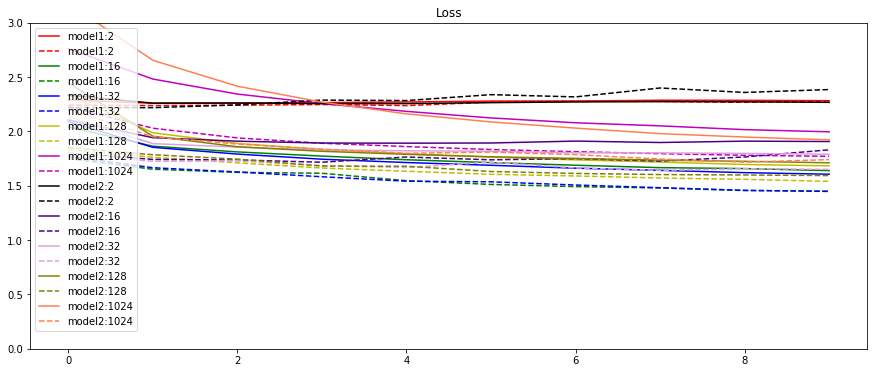

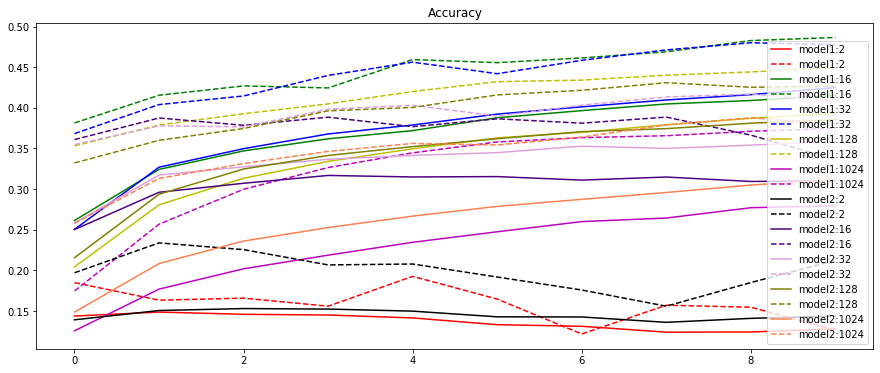

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", 'indigo', 'plum', 'olive', 'coral']

plt.figure(figsize=(15,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 3])
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### 作業三:請於 BN 放在 Input Layer 後，並比較結果